In [1]:
import timeit
import psutil
import sys
import os
import matplotlib.pyplot as plt

from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor as Pool

In [2]:
def measure_runtime(func, params, array):
    start_time = timeit.default_timer()
    func(array, **params)
    end_time = timeit.default_timer()
    runtime = end_time - start_time
    return runtime

Use multiprocessing to run sorts fast

In [3]:
def run_tests_float(sort_functions, funcs_params, input_sizes, input_range,
                    executor=Pool):
    data = {label: [] for _, label in sort_functions}
    with executor(max_workers=cpu_count()) as pool:
        for sort_func, label in sort_functions:
            for size in input_sizes:
                array = random_1_dim_array(
                    elts_range=input_range, size_of_1_dim_range=size)
                data[label].append(
                    pool.submit(measure_runtime, sort_func,
                    funcs_params[str(sort_func.__name__)], array))
        for sort_func, label in sort_functions:
            for i in range(len(data[label])):
                data[label][i] = data[label][i].result()
    return data

In [4]:
def plot_results(data_to_plot):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    for label in data_to_plot:
        ax1.plot([i[0] for i in input_sizes], [sum(runtime)/len(runtime) \
                       for runtime in data_to_plot[label]], marker='o', label=f'{label} (Runtime)')
    ax1.set_xlabel('Input Size')
    ax1.set_ylabel('Runtime (seconds)')
    fig.legend(loc='upper right')
    plt.grid(True)
    plt.title('Sorting Algorithms\' Runtimes')
    plt.show()

def plot_results_log(data_to_plot):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    for label in data_to_plot:
        ax1.plot([i[0] for i in input_sizes], [sum(runtime)/len(runtime) \
                       for runtime in data_to_plot[label]], marker='o', label=f'{label} (Runtime)')
    ax1.set_xlabel('Input Size')
    ax1.set_ylabel('Runtime (seconds)')
    ax1.set_xscale('log')
    fig.legend(loc='upper right')
    plt.grid(True)
    plt.title('Sorting Algorithms\' Runtimes')
    plt.show()

Import written sorts

In [5]:
os.chdir('../../../')
sys.path.append(os.getcwd())


from Algorithms_Python.quick_sort import quick_sort
from Algorithms_Python.merge_sort import merge_sort
from Algorithms_Python.insert_sort import insert_sort
from Algorithms_Python.heap import heap_sort
from Algorithms_Python.tests.test_sorts_and_searches import random_1_dim_array

Stress tests for the research objectives will be divided into 3 parts (by the amount of elements in the sample arrays): 
- start of the curves (up to 100 elements);
- transition part I (100 to 10k elements);
- transition part II (10k to 1kk elements);
- asymptotic part (1kk and 5kk).

Going further is quite a challenge since even a 1kkk elements array would require (a 64-bit system, python's float is 24 bytes) 24 GBs, and anything more than 5kk in size would need at least 15 sec for my algorithms to run, which, multiplied by 10 for statistical purposes, is a lot of time.

The first range (which is below), however, will be chosen to end at 1k elements for the research of general curves behavior

In [6]:
input_sizes = [(1, 1), (5, 5), (10, 10), (50, 50), (100, 100), (500, 500), (1000, 1000)]

sorting_algorithms = [
    (heap_sort, 'Heap Sort'),
    (insert_sort, 'Insertion Sort'),
    (quick_sort, 'Quick Sort'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'heap_sort': {},
    'insert_sort': {},
    'quick_sort': {},
    'merge_sort': {}
}

input_range = (-100, 100)

Everything will be tested for 10 times to get some statistics and remove uncertainty

In [7]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_float(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

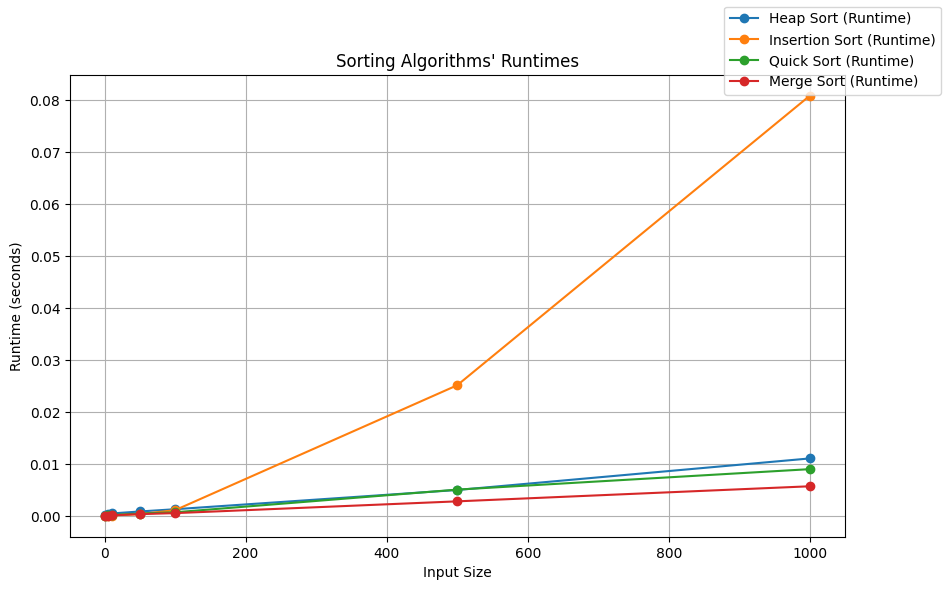

In [8]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

It is clear that while heap, merge and quick sorts are all in one-speed class, insertion sort certainly is in the other.

Let's take a closer look at the performance of the small arrays.

In [9]:
input_sizes = [(1, 1), (5, 5), (10, 10), (20, 20), (50, 50), (70, 70), (100, 100)]

In [10]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_float(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

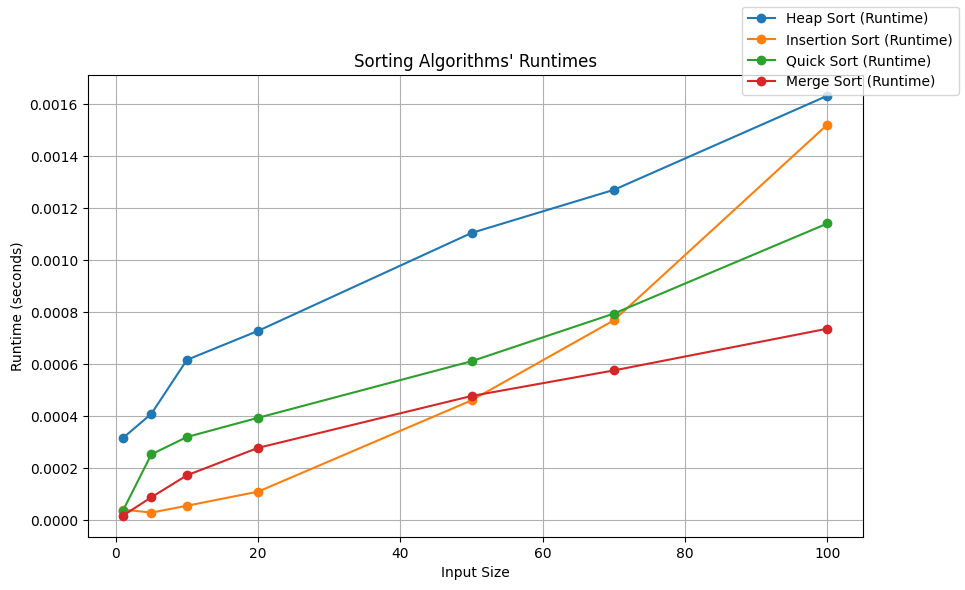

In [11]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

Now we see that on the small arrays (with maximum size between 20 and 50) insertion sort is faster than the others.

Let's see now how these sorts perform in the transitional part.

In [13]:
input_sizes = [(100, 100), (500, 500), (1000, 1000), (5000, 5000), (10000, 10000)]

sorting_algorithms = [
    (heap_sort, 'Heap Sort'),
    (insert_sort, 'Insertion Sort'),
    (quick_sort, 'Quick Sort'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'heap_sort': {},
    'insert_sort': {},
    'quick_sort': {},
    'merge_sort': {}
}

In [14]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_float(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

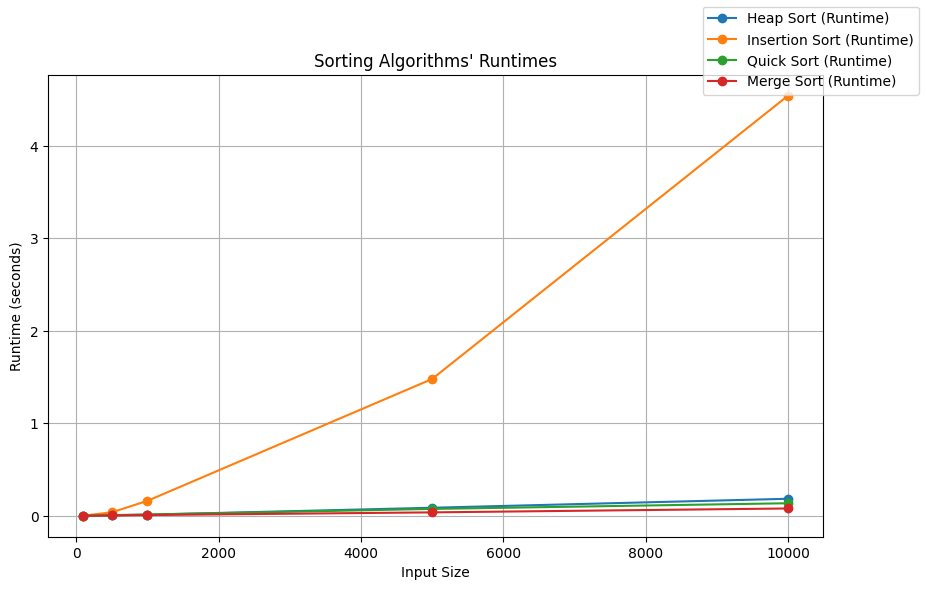

In [15]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

The only thing which can be seen here is the insertion sort graph.
An increase in sample size to 10 times led to an increase of more than 100 times in time consumption. Quadratic dependency for the time. Let's test its optimized implementation instead, where

- A binary search is used to find the insertion point, which reduces the number of comparisons and swaps;

- The number of swaps is minimized by keeping the current element in a separate variable and shifting elements to the right while searching for the insertion point until the correct position is found.

In [16]:
from Algorithms_Python.insert_sort import insert_sort_opt

In [17]:
sorting_algorithms = [
    (heap_sort, 'Heap Sort'),
    (insert_sort_opt, 'Insertion Sort'),
    (quick_sort, 'Quick Sort'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'heap_sort': {},
    'insert_sort_opt': {},
    'quick_sort': {},
    'merge_sort': {}
}

In [18]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_float(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

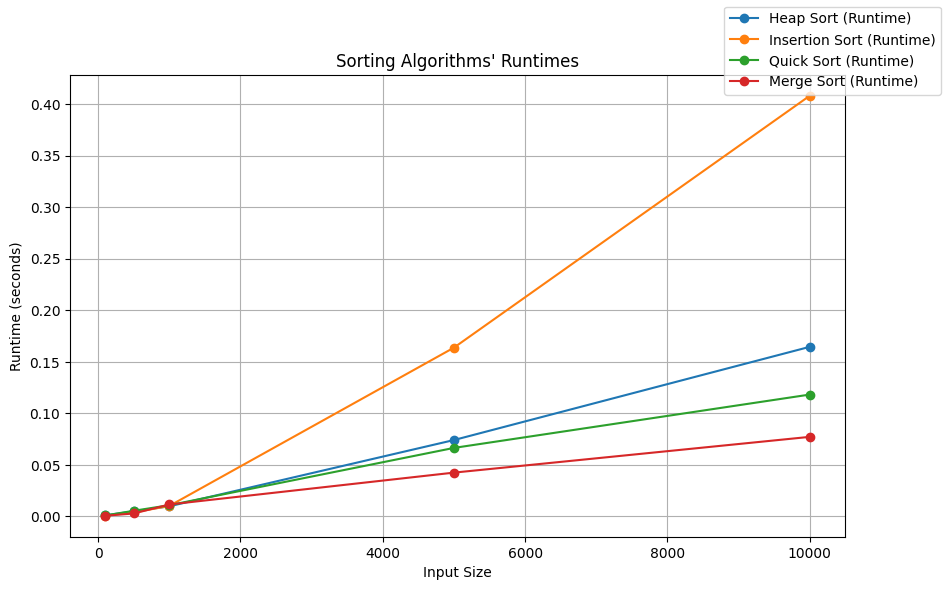

In [19]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

With the new implementation, there is a significant decrease in time consumption (more than 10 times!), however, its quadratic time dependency still makes it not even close to the other sorts with the time difference being at least 2.5 times more than others. Further, an increase in the input size would require much more time than a couple of seconds for a single sort hence, insertion sort will be removed from the consideration as ineffective on larger arrays.

Let's now increase input_size.

In [20]:
input_sizes = [(10000, 10000), (50000, 50000), (100000, 100000), (500000, 500000)]

sorting_algorithms = [
    (heap_sort, 'Heap Sort'),
    (quick_sort, 'Quick Sort'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'heap_sort': {},
    'quick_sort': {},
    'merge_sort': {}
}

In [21]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_float(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

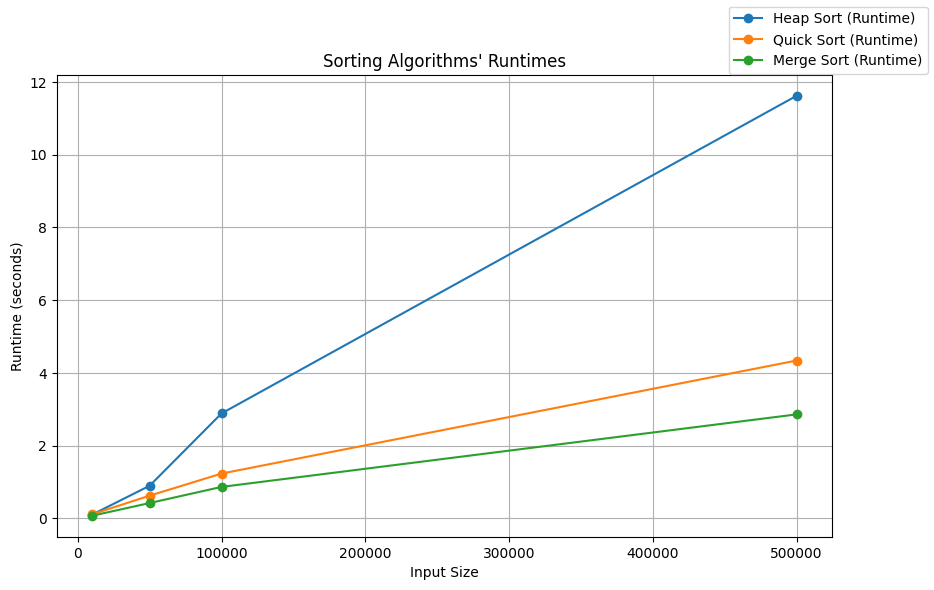

In [22]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

It looks like, time consumption for heap sort now starts to require some time, especially compared to other sorts.

Considering time complexities, heap sort starts to underperform, which can be explained by higher constant factors and less cache-friendly memory allocation patterns than partitioning and merging. It is also important to note that heap sort requires a lot of memory for building heap structure when other sorts are done in place.

Because of this, it will be removed from further consideration.

In [23]:
input_sizes = [(100000, 100000), (500000, 500000), (1000000, 1000000), (5000000, 5000000)]

sorting_algorithms = [
    (quick_sort, 'Quick Sort'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'quick_sort': {},
    'merge_sort': {}
}

In [24]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_float(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

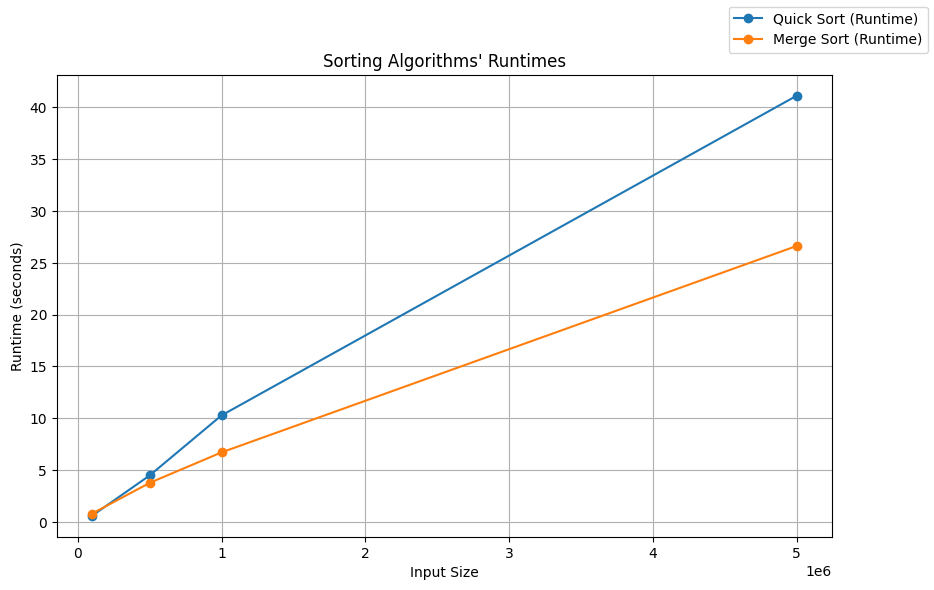

In [25]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

As we can see in the graph - as the input size grows - increases the relative difference in runtime, but not in a linear fashion, which corresponds to O(nlogn) time complexity.

Let's now take the fastest merge_sort and compare its performance to the built-in sorted().

In [26]:
input_sizes = [(1, 1), (5, 5), (10, 10), (50, 50), (100, 100), (500, 500), (1000, 1000),
               (5000, 5000), (10000, 10000), (50000, 50000), (100000, 100000), (500000, 500000), 
               (1000000, 1000000), (5000000, 5000000)]

sorting_algorithms = [
    (sorted, 'Sorted'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'sorted': {},
    'merge_sort': {}
}

In [27]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_float(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

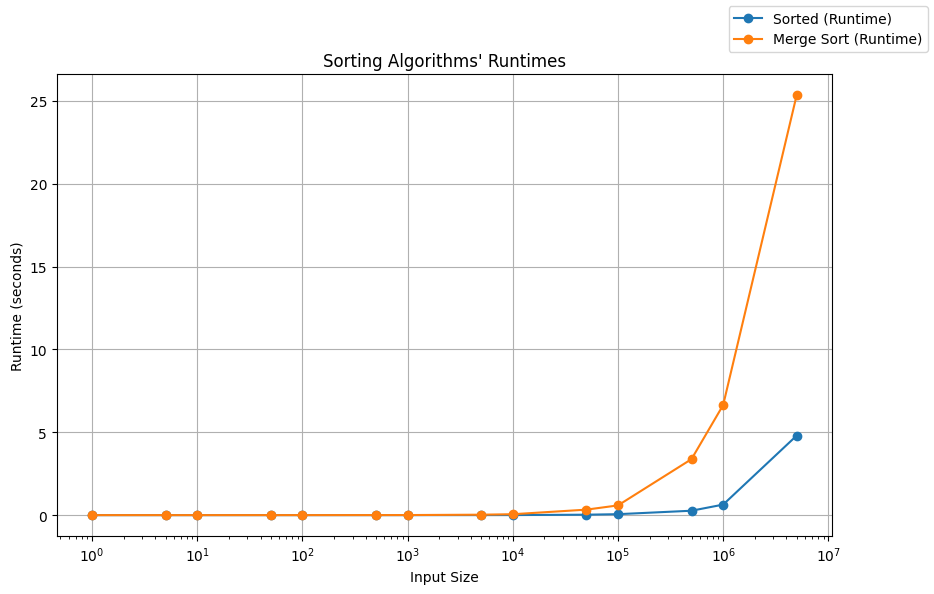

In [30]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results_log(data_to_plot)

And to see the full picture of the sorted() performance limitations we will run the latter with even bigger arrays

In [31]:
input_sizes = [(1000000, 1000000), (5000000, 5000000), (10000000, 10000000), (50000000, 50000000)]

sorting_algorithms = [
    (sorted, 'Sorted')
]

funcs_params = {
    'sorted': {}
}

In [32]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_float(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

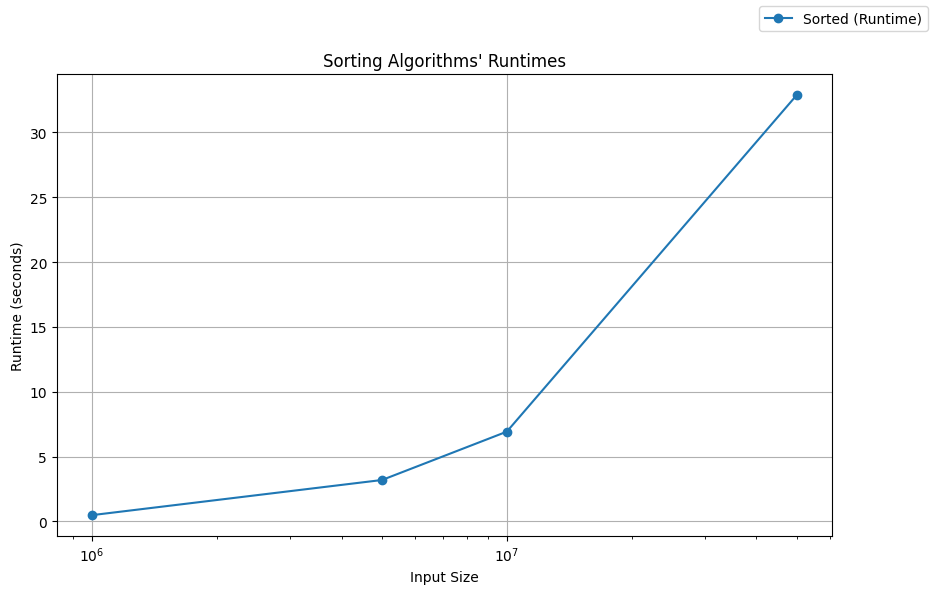

In [33]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results_log(data_to_plot)

And there we can see that the tested implementation of merge sort reaches the same level of performance as the sorted has on just 10 times lesser array.